In [7]:
import itertools
import pathlib
from typing import List

import msgspec
from yoshimidi.data.parse.tracks import Track
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from yoshimidi.data.parse import time_parsing


input_file = pathlib.Path("../out/dataset/02_parsed.jsonl").resolve()

In [8]:
rows = []
with input_file.open("r") as f:
    for line in itertools.islice(f, 10000):
        tracks = msgspec.json.decode(line, type=List[Track])
        for track in tracks:
            for channel in track.channels.values():
                for note in channel.notes:
                    rows.append(note.time_delta_secs)

0.6382972619278862


/var/folders/7w/66fh_d3s5hb0br9f7wtqww1h0000gn/T/ipykernel_33101/2010125915.py:3: RuntimeWarning: divide by zero encountered in log
  a_log = np.log(a)


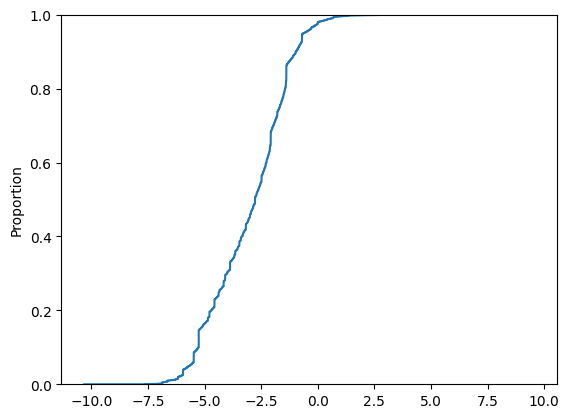

In [9]:
a = np.array(rows)
print((a != 0).mean())
a_log = np.log(a)
a_finite = a_log[np.isfinite(a_log)]
sns.ecdfplot(a_finite)
plt.show()

In [10]:
a_log_min = a_finite.min()
a_log_max = a_finite.max()
print("min, max", a_log_min, a_log_max)
print("less than const min", (a_finite < time_parsing._TIME_LOG_MIN).mean())
print("more than const max", (a_finite > time_parsing._TIME_LOG_MAX).mean())

min, max -10.332669187261608 9.583187990103644
less than const min 1.0722694760590852e-05
more than const max 3.2895582746355414e-06


/var/folders/7w/66fh_d3s5hb0br9f7wtqww1h0000gn/T/ipykernel_33101/2639128135.py:4: RuntimeWarning: invalid value encountered in cast
  a_uint8 = a_uint8.astype(np.uint8)


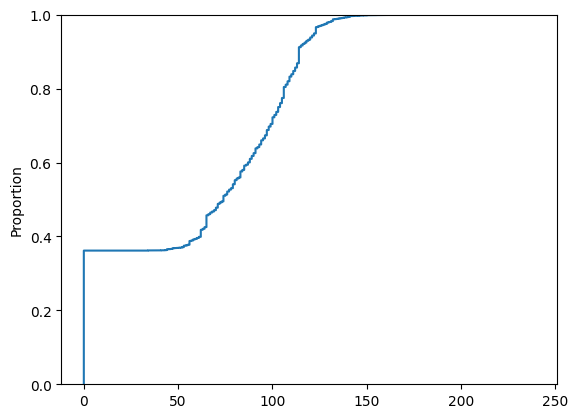

In [11]:
a_uint8 = (a_log - a_log_min) / (a_log_max - a_log_min)
a_uint8[a_uint8 == np.inf] = 0
a_uint8 = a_uint8 * 2**8
a_uint8 = a_uint8.astype(np.uint8)
sns.ecdfplot(a_uint8)
plt.show()

In [12]:
print(np.quantile(a_log, np.arange(0, 1.0001, 0.05)))
print("===")
print(np.quantile(a_finite, np.arange(0, 1.0001, 0.05)))
print("===")
print(np.quantile(a_uint8, np.arange(0, 1.0001, 0.05)))

/Users/misha/src/yoshimidi/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


[        nan         nan         nan         nan         nan         nan
         nan         nan -5.48063892 -5.25749537 -4.56434819 -4.08989821
 -3.4974846  -3.00620357 -2.61669328 -2.24196047 -2.04665172 -1.60943791
 -1.38629436 -0.7532511   9.58318799]
===
[-10.33266919  -5.66297648  -5.26785768  -5.19295635  -4.69787958
  -4.35304016  -4.0047324   -3.68887945  -3.34638965  -3.01678568
  -2.77258872  -2.48490665  -2.2617631   -2.07944154  -1.96165851
  -1.67397643  -1.43758766  -1.38629436  -0.96977942  -0.61310447
   9.58318799]
===
[  0.   0.   0.   0.   0.   0.   0.   0.  62.  65.  74.  80.  87.  94.
  99. 103. 106. 112. 114. 123. 239.]


In [13]:
# Uniform from 0 to 162, then a final bucket for 255.
supports = [*np.arange(0, 162 + 1, 162 / 14), 255.0]
print("supports", supports)
assert len(supports) == 16
assert supports[-2] == 162
df = []
for lower, upper in zip(supports, supports[1:]):
    df.append(
        dict(
            lower=lower,
            upper=upper,
            percent=a_uint8[(lower <= a_uint8) & (a_uint8 < upper)].size / a_uint8.size,
        )
    )
pd.DataFrame(df)

supports [0.0, 11.571428571428571, 23.142857142857142, 34.714285714285715, 46.285714285714285, 57.857142857142854, 69.42857142857143, 81.0, 92.57142857142857, 104.14285714285714, 115.71428571428571, 127.28571428571428, 138.85714285714286, 150.42857142857142, 162.0, 255.0]


,lower,upper,percent
0,0.000000,11.571429,3.617029e-01
1,11.571429,23.142857,2.826541e-07
2,23.142857,34.714286,4.543059e-04
3,34.714286,46.285714,3.964042e-03
4,46.285714,57.857143,2.314384e-02
5,57.857143,69.428571,8.173692e-02
6,69.428571,81.000000,8.122503e-02
7,81.000000,92.571429,8.941693e-02
8,92.571429,104.142857,1.189975e-01
9,104.142857,115.714286,1.559124e-01
